# Packages Import

In [1]:
import numpy as np
import pandas as pd
import ssl
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().magic(u'matplotlib inline')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold, StratifiedKFold
import itertools
import random
from pprint import pprint

# Using Gradient Descent For Model Training

In [2]:
def feature_scaling(train_data):
    
    no_of_columns = train_data.shape[1]
    
    global sd_mean_list
    
    sd_mean_list = []
    
    for index in range(no_of_columns-1):

        sd_val = np.std(train_data[:,index+1])
        mean_val = np.mean(train_data[:,index+1])
        train_data[:,index+1] = (train_data[:,index+1] - mean_val)/(sd_val)
        
        sd_mean_list.append([sd_val,mean_val])
        
    return train_data

In [3]:
def scale_test_data(X_test):
    
    global sd_mean_list
    
    for test_row in X_test:
        
        for index in range(len(test_row)-1):

            mean = sd_mean_list[index][1]
            sd = sd_mean_list[index][0]

            test_row[index+1] = (test_row[index+1] - mean)/sd

    return X_test

In [4]:
def data_preprocessing():
    
    
    df = pd.read_csv("admission_dataset.csv")
    
    df.drop(["Serial No."],inplace = True, axis = 1)
    
    length = df.values.shape[0]
    
    df["bias"] = [1]*length

    cols = df.columns.tolist()
    cols = ['bias', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research', 'Chance of Admit ']
    df = df[cols]
    
    X = df.iloc[:,0:-1]
    Y = df.iloc[:,-1]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
    
    
    Y_train = pd.DataFrame(Y_train)
    Y_train = Y_train.values

    
    Y_test = pd.DataFrame(Y_test)
    Y_test = Y_test.values
    
    
    X_train = feature_scaling(X_train.values)

    X_test = X_test.values
    
    
    return X_train, X_test, Y_train, Y_test 

In [5]:
def regularization_gradient(parameter_list,type_reg = "L2"):
    
    if type_reg == "L2":

        return np.sum(parameter_list) - parameter_list[0][0]
        
    elif type_reg == "L1":
        
        pl = np.asarray([0]*parameter_list.shape[1])
        
        pl[parameter_list[0] < 0] = -1
        pl[parameter_list[0] >= 0] = 1
        
        return np.sum(pl) - pl[0]

In [6]:
def regularization(parameter_list,type_reg):
    
    if type_reg == "L1":
        
        return np.sum(np.absolute(parameter_list))
    
    elif type_reg == "L2":
        
        return np.sqrt(np.sum(np.square(parameter_list)))  

In [53]:
def gradient_descent(X_train,Y_train,params):

    global prediction_error_list, iterations, parameters_change_over_time, lambda_reg_list
    
    iterations = []
    prediction_error_list = []
    parameters_change_over_time = []
    lambda_reg_list = []
    
    learning_rate, error_tolerance, maximum_iterations, lambda_reg, type_reg = params
    
    no_of_columns = X_train.shape[1]
    
    constant_term = 0
    
#     parameter_list = np.random.rand(no_of_columns)
    parameter_list = np.asarray([0]*no_of_columns)
    parameter_list = pd.DataFrame(parameter_list)
    parameter_list = parameter_list.values.T

#     count = 0
    
    
    for index in range(maximum_iterations):

        mse = (np.sum(np.square(np.dot(X_train , parameter_list.T) - Y_train)))/(X_train.shape[0]) + (lambda_reg/X_train.shape[0]) * regularization(parameter_list,type_reg)
        
        if mse < error_tolerance:
            break
        
        gradient = (learning_rate/X_train.shape[0]) * np.dot(X_train.T,(np.dot(X_train , parameter_list.T) - Y_train))+(lambda_reg/X_train.shape[0]) * regularization_gradient(parameter_list,type_reg)
        
        parameter_list = parameter_list - gradient.T

        
        
        if index <= 300 and index%10 == 0:
            iterations.append(index+1)
            prediction_error_list.append(mse)
            parameters_change_over_time.append(parameter_list.tolist()[0])
        
    return parameter_list

In [8]:
def train_classifier(X_train,Y_train,params):
    
    global parameter_list
    
    parameter_list = gradient_descent(X_train,Y_train,params)
    
    return parameter_list

In [42]:
def k_fold_cross_validation(k = 15):
    
    learning_rate = 0.01
    error_tolerance = 1e-09
    maximum_iterations = 10000
    lambda_reg = 0.01
    type_reg = "L2"
    
    params = [learning_rate, error_tolerance, maximum_iterations, lambda_reg, type_reg]
    
    X, x_test, y, Y_test = data_preprocessing()
    
    x_test = scale_test_data(x_test)

    skf = KFold(n_splits=k,shuffle=True,random_state=None)

    model_parameter = None
    error = 0.0
    
    for train_index, test_index in skf.split(X, y):

#         print("TRAIN:", train_index, "TEST:", test_index)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        parameter_list = train_classifier(X_train,y_train,params)

        y_predicted = np.dot(parameter_list,X_test.T)
        
#         print("Error: ",calculate_mse(y_predicted,y_test))
#         print(parameter_list)
        
        if model_parameter is None:
            
            model_parameter = parameter_list
            
            error = calculate_mse(y_predicted,y_test)
            
        else:
            
            if error > calculate_mse(y_predicted,y_test):
                
                model_parameter = parameter_list
                
                error = calculate_mse(y_predicted,y_test)
                
    

    y_predicted = np.dot(model_parameter,x_test.T)
    
    print()
    print("Result on Test data")
    print()
    print("R2 Score: ",calculate_r2_score(y_predicted,Y_test.T))
    print("Mean Square Error: ",calculate_mse(y_predicted,Y_test))
    print("Mean Absolute Error: ",calculate_mea(y_predicted,Y_test))
    print("Mean Percentage Error: ",calculate_mpe(y_predicted,Y_test))
    
    return model_parameter, calculate_mse(y_predicted,Y_test)

In [10]:
def leave_one_out_cross_validation():
    
    learning_rate = 0.01
    error_tolerance = 1e-09
    maximum_iterations = 10000
    lambda_reg = 0.01
    type_reg = "L2"
    
    params = [learning_rate, error_tolerance, maximum_iterations, lambda_reg, type_reg]
    
    X, x_test, y, Y_test = data_preprocessing()
    
    x_test = scale_test_data(x_test)

    loo = LeaveOneOut()

    model_parameter = None
    error = 0.0
    
    for train_index, test_index in loo.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        parameter_list = train_classifier(X_train,y_train,params)

        y_predicted = np.dot(parameter_list,X_test.T)
        
        if model_parameter is None:
            
            model_parameter = parameter_list
            
            error = calculate_mse(y_predicted,y_test)
            
        else:
            
            if error > calculate_mse(y_predicted,y_test):
                
                model_parameter = parameter_list
                
                error = calculate_mse(y_predicted,y_test)
                
    

    y_predicted = np.dot(model_parameter,x_test.T)
    
    print()
    print("Result on Test data")
    print()
    print("R2 Score: ",calculate_r2_score(y_predicted,Y_test.T))
    print("Mean Square Error: ",calculate_mse(y_predicted,Y_test))
    print("Mean Absolute Error: ",calculate_mea(y_predicted,Y_test))
    print("Mean Percentage Error: ",calculate_mpe(y_predicted,Y_test))
    
    return model_parameter

In [11]:
def model_train_validation(params):
    
    X_train, X_test, Y_train, Y_test = data_preprocessing()

    parameter_list = train_classifier(X_train,Y_train,params)

    X_test = scale_test_data(X_test)

    Y_test_predicted = np.dot(parameter_list,X_test.T)
    
    print()
    print("Result on Validation data")
    print()
    print("R2 Score: ",calculate_r2_score(Y_test_predicted,Y_test.T))
    print("Mean Square Error: ",calculate_mse(Y_test_predicted,Y_test))
    print("Mean Absolute Error: ",calculate_mea(Y_test_predicted,Y_test))
    print("Mean Percentage Error: ",calculate_mpe(Y_test_predicted,Y_test))

    return parameter_list

In [12]:
def calculate_r2_score(y_predicted,y_test):

    sum_of_sq = 0
    
    mean_y_test = np.mean(y_test)
    
    sum_of_sq = np.sum(np.square(y_test-mean_y_test))
    
    sum_tot = np.sum(np.square(y_test - y_predicted))
    
    r2_score = 1-(sum_tot/sum_of_sq)
    
    return r2_score

In [13]:
def calculate_mse(y_predicted, y_test):
    
    no_of_rows = y_test.shape[0]
    
    mse = (np.sum(np.square(y_test - y_predicted)))/no_of_rows
    
    return mse

In [14]:
def calculate_mea(y_predicted, y_test):

    no_of_rows = y_test.shape[0]
    
    mea = (np.sum(abs(y_test - y_predicted)))/no_of_rows
    
    return mea

In [15]:
def calculate_mpe(y_predicted, y_test):
    
    no_of_rows = y_test.shape[0]

    mpe = np.sum((y_test - y_predicted)/y_test)
    
    mpe = (1/no_of_rows)*mpe
    
    return mpe

# Using Scikit Learn Library

In [16]:
def model_using_sklearn():
    
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score


    dataset = pd.read_csv('admission_dataset.csv')
    x = dataset.iloc[:, 1:-1].values
    y = dataset.iloc[:, -1].values

    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = .2, random_state = 0)

    linearRegressor = LinearRegression()
    linearRegressor.fit(xTrain, yTrain)
    yPrediction = linearRegressor.predict(xTest)

    print()
    print("Using Sklearn Library On Validation Data")
    print()

    print("R2 Score: ",calculate_r2_score(yPrediction,yTest))
    print("Mean Square Error: ",calculate_mse(yPrediction,yTest))
    print("Mean Absolute Error: ",calculate_mea(yPrediction,yTest))
    print("Mean Percentage Error: ",calculate_mpe(yPrediction,yTest))
    
    return linearRegressor

In [17]:
def evaluation_sk_learn(filename):
    
    linearRegressor = model_using_sklearn()

    dataset = pd.read_csv(filename)
    x = dataset.iloc[:, 1:-1].values
    y = dataset.iloc[:, -1].values

    
    yPrediction = linearRegressor.predict(x)

    print()
    print("Using Sklearn Library On Test Data")
    print()

    print("R2 Score: ",calculate_r2_score(yPrediction,y))
    print("Mean Square Error: ",calculate_mse(yPrediction,y))
    print("Mean Absolute Error: ",calculate_mea(yPrediction,y))
    print("Mean Percentage Error: ",calculate_mpe(yPrediction,y))    

# Using Normal Equation For Model Training

In [18]:
def normal_equation():
    
    df = pd.read_csv("admission_dataset.csv")
    df.drop(["Serial No."],inplace = True, axis = 1)

    length = len(df.values)

    df["bias"] = [1]*length

    cols = df.columns.tolist()

    cols = ['bias', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research', 'Chance of Admit ']
    df = df[cols]


    X = df.iloc[:,0:-1]
    Y = df.iloc[:,-1]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)


    X_train = X_train
    X_test = X_test
    Y_test = Y_test.values
    Y_train = Y_train.values

    model = np.dot(np.dot(np.linalg.inv(np.dot(X_train.T,X_train)),X_train.T),Y_train)

    Y_test_predicted = np.dot(X_test,model)

    print("R2 Score: ",calculate_r2_score(Y_test_predicted,Y_test))
    print("Mean Square Error: ",calculate_mse(Y_test_predicted,Y_test))
    print("Mean Absolute Error: ",calculate_mea(Y_test_predicted,Y_test))
    print("Mean Percentage Error: ",calculate_mpe(Y_test_predicted,Y_test))

In [19]:
normal_equation()

R2 Score:  0.7732955450686257
Mean Square Error:  0.0032450195796833795
Mean Absolute Error:  0.0419965072776302
Mean Percentage Error:  0.0009783869771530522


In [20]:
def evaluation(filename):
    
    global test_file_name
    
    test_file_name = filename
        
    learning_rate = 0.01
    error_tolerance = 1e-06
    maximum_iterations = 10000
    lambda_reg = 0.01
    type_reg = "L2"
    
    params = [learning_rate, error_tolerance, maximum_iterations, lambda_reg, type_reg]
    
    #Train regression model
    parameter_list =  model_train_validation(params)
    
    df = pd.read_csv(filename)
    
    df.drop(["Serial No."],inplace = True, axis = 1)
    
    length = df.values.shape[0]
    
    df["bias"] = [1]*length

    cols = df.columns.tolist()
    cols = ['bias', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research', 'Chance of Admit ']
    df = df[cols]
    
    X = df.iloc[:,0:-1]
    Y = df.iloc[:,-1]
    
    X = scale_test_data(X.values)
    
    Y_predicted = np.dot(X,parameter_list.T)
    

    Y = pd.DataFrame(Y)
    Y = Y.values
    
    
    print()
    print("Result on Test Data")
    print()
    print("R2 Score: ",calculate_r2_score(Y_predicted,Y))
    print("Mean Square Error: ",calculate_mse(Y_predicted,Y))
    print("Mean Absolute Error: ",calculate_mea(Y_predicted,Y))
    print("Mean Percentage Error: ",calculate_mpe(Y_predicted,Y))
    
    print()
    print()
    print("Residual Plot Using Custom Implementation of Linear Regression")
    print()
    
    residual_plot(Y_predicted,Y)

# Data Visualization

In [21]:
def error_vs_iteration_plot():
    
    global iterations, prediction_error_list
    
    prediction_error_df = pd.DataFrame(
    {'Iterations': iterations,
     'Error': prediction_error_list
    })

    prediction_error_df = prediction_error_df.melt('Iterations',  value_name='Error')
    prediction_error_df_graph = sns.factorplot(x="Iterations", y="Error", data = prediction_error_df)

In [22]:
def error_vs_regularization_plot():
    
    learning_rate = 0.01
    error_tolerance = 1e-09
    maximum_iterations = 10000
    lambda_reg = 0.01
    type_reg = "L2"
    
    validation_prediction_error_list = []
    train_prediction_error_list = []
    lambda_reg_list = [0.00001,0.0004,0.008,0.016,0.032,0.128,0.256,0.512,1.024,2.048,3,4,5,6]
    
    X_train, X_test, Y_train, Y_test = data_preprocessing()
    X_test = scale_test_data(X_test)
    
    for l_reg in lambda_reg_list:
        
        params = [learning_rate, error_tolerance, maximum_iterations, l_reg, type_reg]

        parameter_list = train_classifier(X_train,Y_train,params)

        Y_predicted_val = np.dot(parameter_list,X_test.T)
        validation_prediction_error_list.append(calculate_mse(Y_predicted_val,Y_test))
        
        Y_predicted_train = np.dot(parameter_list,X_train.T)
        
#         print(Y_predicted_train)
#         print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
#         print(Y_train.T)
        
        train_prediction_error_list.append(calculate_mse(Y_predicted_train,Y_train.T))
        
    
#     print(train_prediction_error_list)
#     print(validation_prediction_error_list)
    
    error_vs_regularization_df = pd.DataFrame(
    {'Regularisation Coefficent': lambda_reg_list,
     'Validation Data Error': validation_prediction_error_list,
     'Train Data Error': train_prediction_error_list
    })

    error_vs_regularization_df = error_vs_regularization_df.melt('Regularisation Coefficent', var_name = "Data" ,value_name='Error')
    error_vs_regularization_df_graph = sns.factorplot(x="Regularisation Coefficent", y="Error",hue = 'Data', data = error_vs_regularization_df)
    
    
    error_vs_regularization_df_graph.savefig("error_vs_regularization_L2_graph.png")
    
##########################################################################################################    
    
    learning_rate = 0.01
    error_tolerance = 1e-09
    maximum_iterations = 10000
    lambda_reg = 0.01
    type_reg = "L1"
    
    validation_prediction_error_list = []
    train_prediction_error_list = []
    lambda_reg_list = [0.00001,0.0004,0.008,0.016,0.032,0.128,0.256,0.512]
    
    
    X_train, X_test, Y_train, Y_test = data_preprocessing()
    X_test = scale_test_data(X_test)
    
    for l_reg in lambda_reg_list:
        
        params = [learning_rate, error_tolerance, maximum_iterations, l_reg, type_reg]

        parameter_list = train_classifier(X_train,Y_train,params)

        Y_predicted_val = np.dot(parameter_list,X_test.T)
        validation_prediction_error_list.append(calculate_mse(Y_predicted_val,Y_test))
        
        Y_predicted_train = np.dot(parameter_list,X_train.T)
        
#         print(Y_predicted_train)
#         print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
#         print(Y_train.T)
        
        train_prediction_error_list.append(calculate_mse(Y_predicted_train,Y_train.T))
        
    
#     print(train_prediction_error_list)
#     print(validation_prediction_error_list)
    
    error_vs_regularization_df = pd.DataFrame(
    {'Regularisation Coefficent': lambda_reg_list,
     'Validation Data Error': validation_prediction_error_list,
     'Train Data Error': train_prediction_error_list
    })

    error_vs_regularization_df = error_vs_regularization_df.melt('Regularisation Coefficent', var_name = "Data" ,value_name='Error')
    error_vs_regularization_df_graph = sns.factorplot(x="Regularisation Coefficent", y="Error",hue = 'Data', data = error_vs_regularization_df)
    
    
    error_vs_regularization_df_graph.savefig("error_vs_regularization_L1_graph.png")

/home/prakashjha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


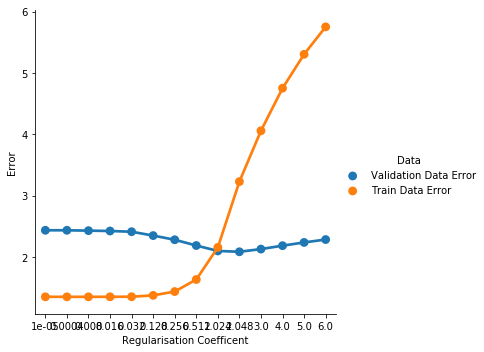

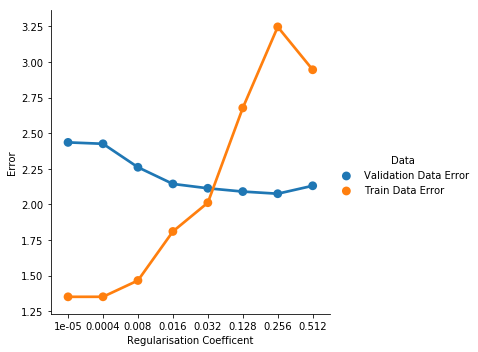

In [52]:
error_vs_regularization_plot()

In [24]:
def error_vs_parameters(type_reg = "L2"):
    
    learning_rate = 0.01
    error_tolerance = 1e-06
    maximum_iterations = 100000
    lambda_reg = 0.01
        
    X_train, X_test, Y_train, Y_test = data_preprocessing()
    X_test = scale_test_data(X_test)
    
    params = [learning_rate, error_tolerance, maximum_iterations, lambda_reg, type_reg]
    parameter_list = train_classifier(X_train,Y_train,params)
    
    
    global prediction_error_list,parameters_change_over_time

    headers = ['Bias', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']

    parameters = pd.DataFrame(parameters_change_over_time, columns=headers)

    parameters["Error"] = prediction_error_list

    iterations = []

    for index in range(len(parameters_change_over_time)):
        iterations.append(index+1)


    parameters["Iterations"] = iterations


    f, ax = plt.subplots(1, 1)
    x_col='Iterations'
    y_col = 'Variations'

    ax.plot(parameters.Iterations, parameters["SOP"],  label="SOP", linestyle="-")
    ax.plot(parameters.Iterations, parameters["LOR"],  label="LOR", linestyle="-")
    ax.plot(parameters.Iterations, parameters["CGPA"], label="CGPA", linestyle="-")
    ax.plot(parameters.Iterations, parameters["Research"],  label="Research", linestyle="-")
    ax.plot(parameters.Iterations, parameters["GRE Score"],  label="GRE Score", linestyle="-")
    ax.plot(parameters.Iterations, parameters["TOEFL Score"], label="TOEFL Score", linestyle="-")
    ax.plot(parameters.Iterations, parameters["University Rating"],  label="University Rating", linestyle="-")

    ax.set_xlabel('Iterations')
    ax.set_ylabel('Variations of Coeffiecent of Features')

    ax.legend()
    plt.show()

    f, axis = plt.subplots(1, 1)
    x_col='Error'
    y_col = 'Variations'

    axis.plot(parameters.Error, parameters["SOP"],  label="SOP", linestyle="-")
    axis.plot(parameters.Error, parameters["LOR"],  label="LOR", linestyle="-")
    axis.plot(parameters.Error, parameters["CGPA"], label="CGPA", linestyle="-")
    axis.plot(parameters.Error, parameters["Research"],  label="Research", linestyle="-")
    axis.plot(parameters.Error, parameters["GRE Score"],  label="GRE Score", linestyle="-")
    axis.plot(parameters.Error, parameters["TOEFL Score"], label="TOEFL Score", linestyle="-")
    axis.plot(parameters.Error, parameters["University Rating"],  label="University Rating", linestyle="-")

    axis.set_xlabel('Error')
    axis.set_ylabel('Variations of Coeffiecent of Features')

    axis.invert_xaxis()

    axis.legend()
    plt.show()

In [48]:
def kfold_mse():
    
    k_list = [2,3,4,5,6,7,8,10,15,20,25,30,35,40,50,60,70,80,90,100]
    mse_list = []
    error = 0
    
    for k in k_list: 
        
        model,error = k_fold_cross_validation(k)
        
        mse_list.append(error)
        
    error_vs_k_df = pd.DataFrame(
    {'K': k_list,
     'Error': mse_list
    })

    error_vs_k_df = error_vs_k_df.melt('K' ,value_name='Error')
    error_vs_k_df_graph = sns.factorplot(x="K", y="Error", data = error_vs_k_df)
  
    
    


Result on Test data

R2 Score:  0.7746572817623051
Mean Square Error:  2.4459644092609225
Mean Absolute Error:  11.933797841127957
Mean Percentage Error:  -2.6780940982364343

Result on Test data

R2 Score:  0.7787454855243383
Mean Square Error:  2.4302771934813294
Mean Absolute Error:  11.904054055700474
Mean Percentage Error:  -2.2316283708516367

Result on Test data

R2 Score:  0.7723606372760785
Mean Square Error:  2.477639418342214
Mean Absolute Error:  12.029833263343319
Mean Percentage Error:  -2.052912960449132

Result on Test data

R2 Score:  0.7761998105339161
Mean Square Error:  2.39527231834636
Mean Absolute Error:  11.815250059885743
Mean Percentage Error:  -2.324726777245419

Result on Test data

R2 Score:  0.7746337702396775
Mean Square Error:  2.4588476772172787
Mean Absolute Error:  11.970826062697178
Mean Percentage Error:  -1.9618204831809756

Result on Test data

R2 Score:  0.771146848950568
Mean Square Error:  2.42141698301389
Mean Absolute Error:  11.878702694437

/home/prakashjha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


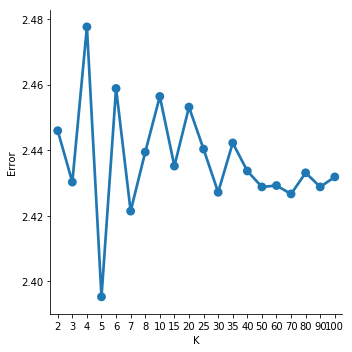

In [54]:
kfold_mse()

In [25]:
def residual_plot(ypredicted,ytest):
    
   
    errors = ytest - ypredicted
    
    ypredict = list(itertools.chain(*ypredicted))
    error = list(itertools.chain(*errors))
    
    residual_error_df = pd.DataFrame(
    {'Prdeicted Values': ypredict,
     'Error': error
    })

    residual_error_df = residual_error_df.melt('Prdeicted Values',  value_name='Error')

    sns.lmplot('Prdeicted Values', 'Error', data=residual_error_df, fit_reg=False)

# Question 1 - 3 - 1 and 1 -3 - 2


Using Sklearn Library On Validation Data

R2 Score:  0.7732955450687018
Mean Square Error:  0.0032450195796822905
Mean Absolute Error:  0.04199650727761043
Mean Percentage Error:  0.0009783869770144547

Using Sklearn Library On Test Data

R2 Score:  0.816973552388422
Mean Square Error:  0.003651192343817597
Mean Absolute Error:  0.04335947920261959
Mean Percentage Error:  -0.008547922305384894

Result on Validation data

R2 Score:  0.7732511125845698
Mean Square Error:  2.4279934952760516
Mean Absolute Error:  11.896316219195295
Mean Percentage Error:  -2.016526990373679

Result on Test Data

R2 Score:  0.8169493389172802
Mean Square Error:  0.0036516753780544736
Mean Absolute Error:  0.04342772621124992
Mean Percentage Error:  -0.008048271990876496


Residual Plot Using Custom Implementation of Linear Regression



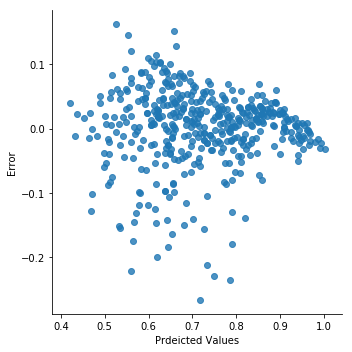

In [26]:
test_filename = "admission_dataset.csv"

evaluation_sk_learn(test_filename)

evaluation(test_filename)

# Question 1 - 3 - 3

/home/prakashjha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


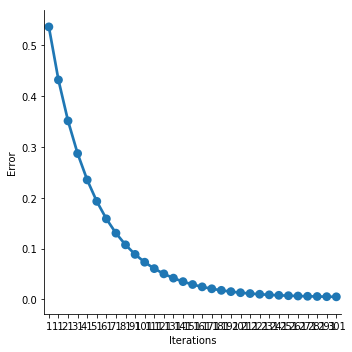

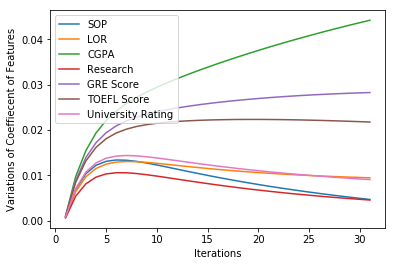

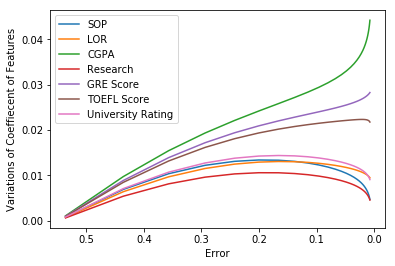

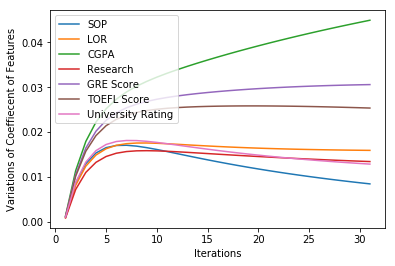

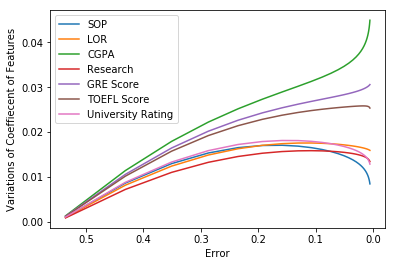

In [27]:
error_vs_iteration_plot()
error_vs_parameters(type_reg = "L1")
error_vs_parameters(type_reg = "L2")

In [28]:
model,mse = k_fold_cross_validation()


Result on Test data

R2 Score:  0.7727720426477112
Mean Square Error:  2.437517695180964
Mean Absolute Error:  11.920289884632929
Mean Percentage Error:  -1.8572158790566657


In [29]:
model,mse = leave_one_out_cross_validation()


Result on Test data

R2 Score:  0.7732509772075844
Mean Square Error:  2.4279920123731182
Mean Absolute Error:  11.896312045811676
Mean Percentage Error:  -2.016551431140276


## Observations

From the graph between Error vs Iteration we can observe that with every iteration there is decrease in error which signals correct implementation of Gradient Descent algorithm used for training the linear regression model 

From the above Error vs Variation of coefficent features we can cleary obesrve that with increase in coefficient values there is a decrease in error. Moreover from the graph it very evifent that CGPA, TOEFL Score, GRE Score play more significant role as comapared to other features as the have higher coefficent values.

From the graph Error vs Variation of coefficent features we can see that with every epoch or iteration of entire dataset there is an increase in coefficent values for the features in the dataset which tend to suggest direct proportionality among feature value and label which is "Chance of Admit"